<h1 align=center> Potato Disease Classification </h1> <br>
<h3 align=right> 
    Vibhav Shukla 
    102003772 <br>
    Arnav Negi
    
 </h3>
 

### Importing required libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

### Declaring model-wide constants

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3 #RGB Channels
EPOCHS=20

### Setting up the dataset

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32
)

Found 20638 files belonging to 15 classes.


In [6]:
len(dataset) #the len is 68 because the image is loaded in 68 batches of size 32

645

### Getting the classnames

In [7]:
#tf automatically marks the foldernames as classnames
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

### Checking the images

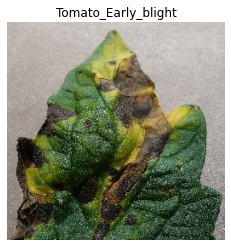

In [8]:
for image_batch, label_batch in dataset.take(1): #loads a batch of 32 images
    #astype("uint8") is required as otherwise, it will load in float values and not int
    plt.imshow(image_batch[0].numpy().astype("uint8")) #we will take the first image of batch 
    plt.title(class_names[label_batch[0]]) 
    #label_batch[0] gives the label as 0,1,2. Hence we use it as a index of our list, class_names
    plt.axis("off") #it was showing the image size, 256x256

##### We see a different image everytime because we have set shuffle=true

### Checking 15 images

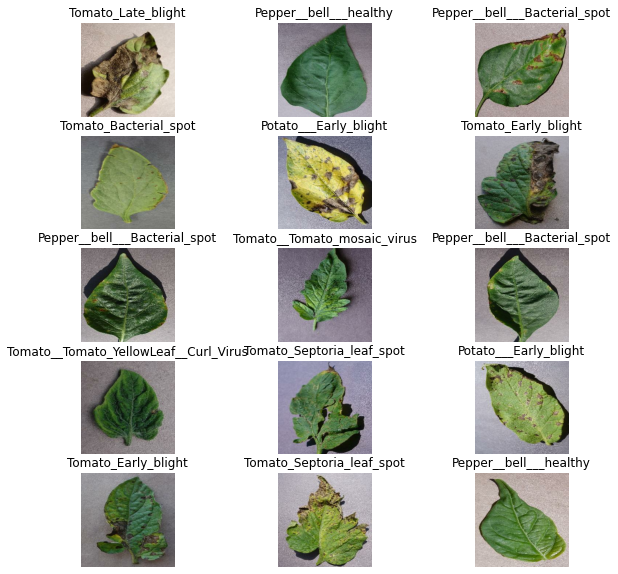

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): 
    for i in range(15):
        ax=plt.subplot(5,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]]) 
        plt.axis("off") 

## Splitting Dataset into test and training

### Using 80% of the Dataset for Training, 10% for validation and 10% for Testing

In [10]:
train_size=int(0.8*len(dataset))
train_size

516

In [11]:
train_ds=dataset.take(train_size)
len(train_ds)

516

In [12]:
test_ds=dataset.skip(train_size)
len(test_ds)

129

#### Now test_ds will be divided into validation_ds and test_ds

In [13]:
val_size=int(0.1*len(dataset))
val_size

64

In [14]:
val_ds=test_ds.take(val_size)
len(val_ds)

64

In [15]:
test_ds=test_ds.skip(val_size)
len(test_ds)

65

### We can create a function to replace all this
more on shuffling size:https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset

In [16]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = split_dataset(dataset)

### Prefetching and Caching

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data-PreProcessing Layer

In [19]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augumentation Layer

In [20]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Building the model - CNN

In [21]:
n_classes=15
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model=models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),#pooling layer, preserving the features and reducing the size
    layers.Conv2D(64,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax') #softmax activation normalises the probability of classes
    
])

model.build(input_shape=input_shape)

### Printing the model summary

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### fitting the model

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
516/516 [==============================] - 163s 208ms/step - loss: 1.9937 - accuracy: 0.3453 - val_loss: 1.8802 - val_accuracy: 0.4077
Epoch 2/50
151/516 [=======>......................] - ETA: 43s - loss: 1.3110 - accuracy: 0.5604

KeyboardInterrupt: 

## TESTING THE MODEL

In [ ]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 204ms/step - loss: 0.0230 - accuracy: 0.9961


In [ ]:
print ("loss", scores[0])
print ("accuracy", scores[1]*100)

loss 0.02301303669810295
accuracy 99.609375


### HISTORY 
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
print(history) #it is a keras history object

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
len(history.history['accuracy'])

50

##### 50 length is for 50 epochs

Text(0.5, 1.0, 'Loss')

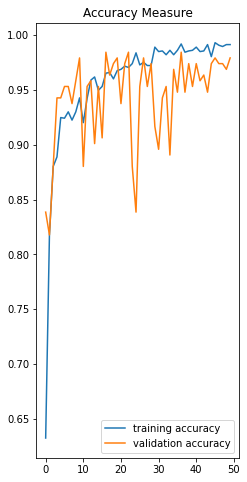

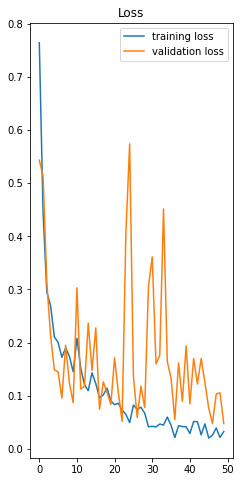

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='training accuracy')
plt.plot(range(EPOCHS), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Measure')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='training loss')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('Loss')

### Loss is an error

# PREDICTIONS

image to predict
actual label: Potato___Early_blight
[1.000000e+00 5.271018e-08 1.498472e-22]


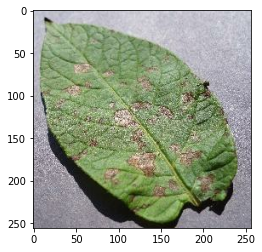

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print(batch_prediction[0])

##### We get a array with 3 elements, as we had 3 neural networks, and we used softmax activation function, which gives probabilities.

In [ ]:
#to find the index of the maximum element
print(np.argmax(batch_prediction[0]))

0


In [ ]:
#to get the label
print(class_names[np.argmax(batch_prediction[0])])

Potato___Early_blight


## Now comparing the predictions

image to predict
actual label: Potato___Late_blight
[4.5278217e-04 9.9954718e-01 7.8515172e-10]
predicted label: Potato___Late_blight


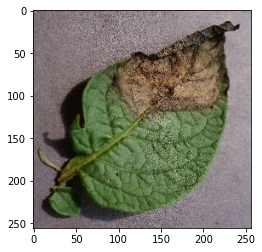

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Creating a predict model function which returns the predicted model and the confidence

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0) #create a batch
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100 *  (np.max(predictions[0])),2)
    return predicted_class, confidence

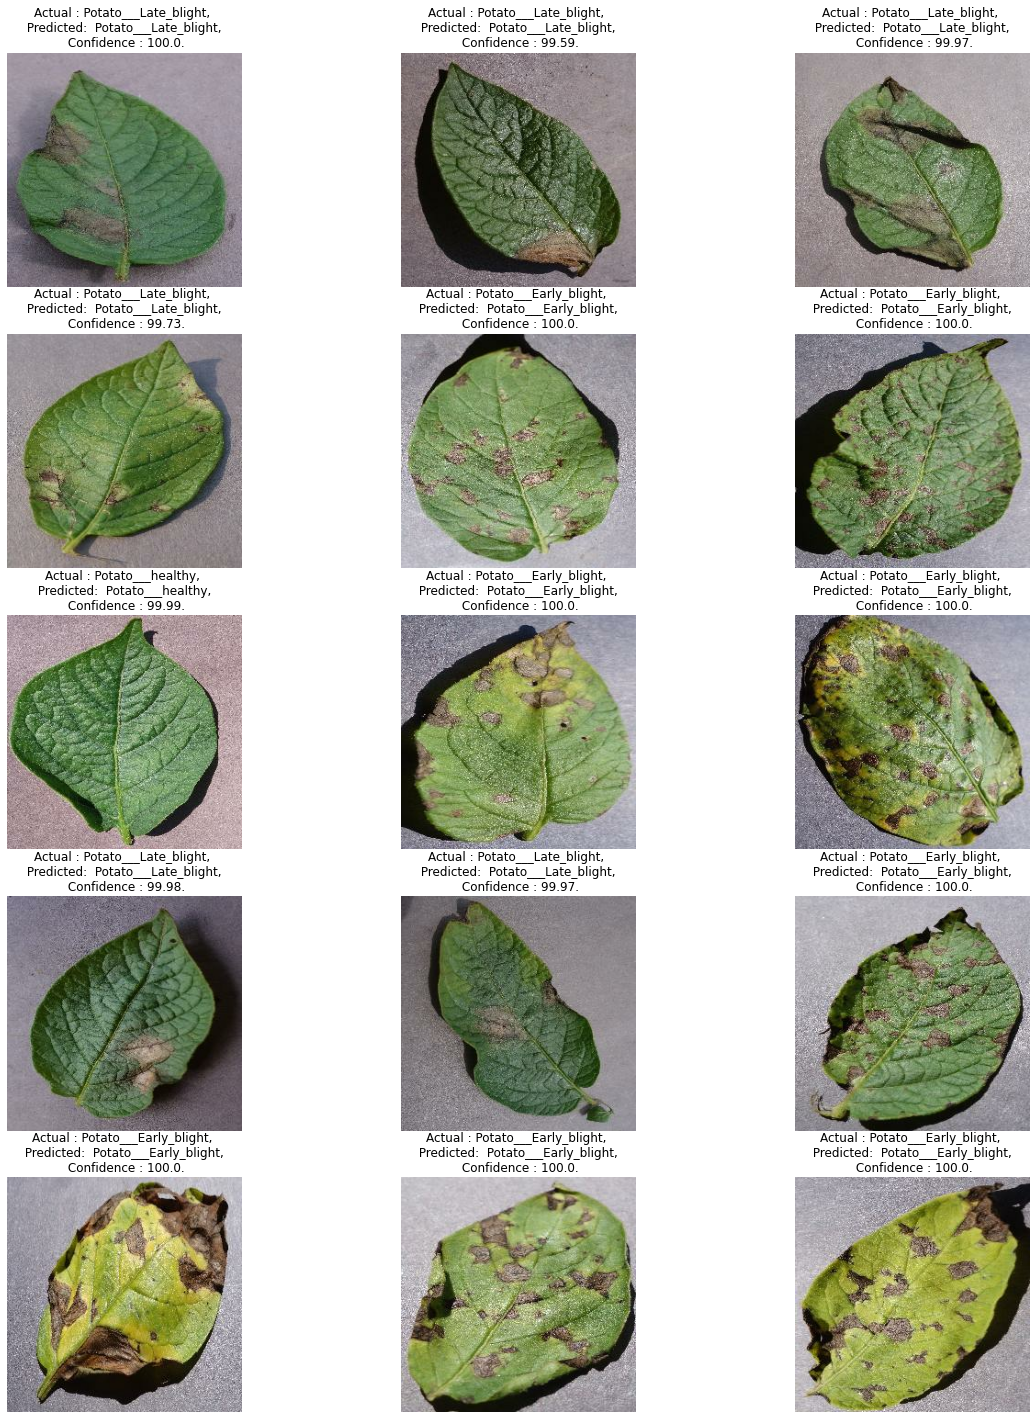

In [ ]:
plt.figure(figsize=(20,25))
for images , labels in test_ds.take(1):
    for i in range(15):
        ax=plt.subplot(5,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual : {actual_class}, \n Predicted:  {predicted_class}, \n Confidence : {confidence}.")
        plt.axis("off")

# Saving the model


In [ ]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
